In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import rmm
rmm.mr.set_current_device_resource(rmm.mr.ManagedMemoryResource())
print("MANAGED MEMORY ON")


MANAGED MEMORY ON


In [3]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score
import cuml
import numpy as np
import os
import time
import json

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# X_arr, y_arr = cuml.datasets.make_blobs(
#         n_samples=1000,
#         n_features=16,
#         centers=None,
#         random_state=42,
#         dtype=np.float32,
#     )

In [5]:
# data = (X_arr, y_arr, None, None)

In [6]:
n_samples = 50000000
n_features = 256

n_clusters = 8
random_state = 0


In [7]:
device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std=0.1
)


In [8]:
kmeans_cuml = cuKMeans(
    init="k-means||",
    n_clusters=n_clusters,
    random_state=random_state
)

%timeit kmeans_cuml.fit(device_data)


16.9 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:



# cuml.common.logger.set_level(1)

class Timer:
    def __enter__(self):
        self.tick = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick


# Warmup
X = np.random.normal(0, 10, (100, 20))
y = np.random.randint(0, 2, 100)
clf = cuml.ensemble.RandomForestRegressor().fit(X, y)
clf = cuml.neighbors.KNeighborsRegressor().fit(X, y)


# n_samples = 50000000
# n_features = 256
# n_clusters = 8
# random_state = 0



# PARAMS
SKIP_SKLEARN = True

BACKENDS = [
    "cuml",
    "sklearn",
]

if SKIP_SKLEARN:
    BACKENDS.remove("sklearn")

NROWS = [
    # 10000000,
    # 20000000,
    # 30000000,
    # 40000000,
    # 50000000,
    # 60000000,
    70000000,
    80000000,
    90000000,
    100000000
]

NFEATURES = [
    256,
]

del clf


outpath = f"kmeans-benchmark-results-uvm-70.jsonl"
if os.path.exists(outpath):
    os.remove(outpath)


for N in NROWS:
    for K in NFEATURES:
        for library in BACKENDS:

            device_data, device_labels = make_blobs(
                n_samples=N,
                n_features=K,
                centers=8,
                random_state=0,
                cluster_std=0.1
            )
            del device_labels


            benchmark_payload = {}
            with Timer() as fit_time:
                if library == "cuml":
                    kmeans_cuml = cuKMeans(
                        init="k-means||",
                        n_clusters=8,
                        random_state=0
                    )

                    kmeans_cuml.fit(device_data)

            benchmark_payload["backend"] = library
            benchmark_payload["nrows"] = N
            benchmark_payload["ncols"] = K
            benchmark_payload["fit_time"] = fit_time.elapsed
            benchmark_payload["managed_memory"] = 1
            print(benchmark_payload)

            with open(outpath, "a") as fh:
                fh.write(json.dumps(benchmark_payload))
                fh.write("\n")
            del kmeans_cuml
            del device_data

            time.sleep(0.5)

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


CUDADriverError: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

In [4]:
class Timer:
    def __enter__(self):
        self.tick = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick


device_data, device_labels = make_blobs(
    n_samples=40000000,
    n_features=256,
    centers=8,
    random_state=0,
    cluster_std=0.1
)


benchmark_payload = {}
with Timer() as fit_time:
    kmeans_cuml = cuKMeans(
        init="k-means||",
        n_clusters=8,
        random_state=0
    )

    kmeans_cuml.fit(device_data)



In [5]:
import pandas as pd


In [6]:
uvm_df = pd.read_json(path_or_buf="kmeans-benchmark-results-uvm.jsonl", lines=True)
no_uvm_df = pd.read_json(path_or_buf="kmeans-benchmark-results-no-uvm.jsonl", lines=True)

In [13]:
uvm_df

,backend,nrows,ncols,fit_time,managed_memory
0,cuml,10000000,256,2.910753,1
1,cuml,20000000,256,5.495676,1
2,cuml,30000000,256,8.256163,1
3,cuml,40000000,256,15.919971,1
4,cuml,50000000,256,18.055269,1
5,cuml,60000000,256,26.473229,1


In [15]:
no_uvm_df["managed_memory"]=0

In [16]:
df = pd.concat([uvm_df, no_uvm_df])

In [21]:
df.to_csv("kmeans_sum.csv", index=False)

In [18]:
import matplotlib as plt

In [19]:
pivot = df.pivot(index='nrows', columns='managed_memory', values='fit_time')


<Axes: xlabel='nrows'>

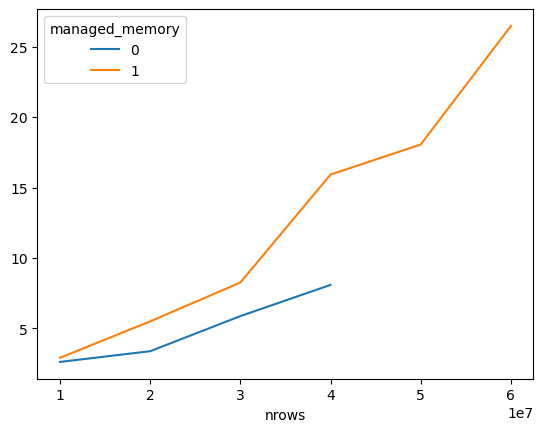

In [20]:
pivot.plot()

In [22]:
pivot


managed_memory,0,1
nrows,,
10000000,2.616952,2.910753
20000000,3.378033,5.495676
30000000,5.870863,8.256163
40000000,8.086620,15.919971
50000000,NaN,18.055269
60000000,NaN,26.473229


# RANDOM FOREST

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import rmm
rmm.mr.set_current_device_resource(rmm.mr.ManagedMemoryResource())
print("MANAGED MEMORY ON")


MANAGED MEMORY ON


In [3]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.metrics import accuracy_score
from cuml.datasets.classification import make_classification
from cuml.model_selection import train_test_split
import pandas as pd
import cuml
import numpy as np
import os
import time
import cupy as cp
import json

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# cuml.common.logger.set_level(1)

class Timer:
    def __enter__(self):
        self.tick = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick


# Warmup
X = np.random.normal(0, 10, (100, 20))
y = np.random.randint(0, 2, 100)
clf = cuml.ensemble.RandomForestRegressor().fit(X, y)
clf = cuml.neighbors.KNeighborsRegressor().fit(X, y)


# n_samples = 50000000
# n_features = 256
# n_clusters = 8
# random_state = 0



# PARAMS
SKIP_SKLEARN = True

BACKENDS = [
    "cuml",
    "sklearn",
]

if SKIP_SKLEARN:
    BACKENDS.remove("sklearn")

NROWS = [
    5000000,
    10000000,
    15000000,
    20000000,
    25000000,
    30000000,
    40000000,
    50000000,
    60000000,
    70000000,
    80000000,
    90000000,
    100000000
]

NFEATURES = [
    256,
]

del clf


outpath = f"rf-benchmark-results-uvm.jsonl"
if os.path.exists(outpath):
    os.remove(outpath)


for N in NROWS:
    for K in NFEATURES:
        for library in BACKENDS:
            X, y = make_classification( n_features = K,
                             n_samples = N,
                             random_state = 0 )
            X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 0 )


            benchmark_payload = {}
            with Timer() as fit_time:
                if library == "cuml":
                    cuml_model = cuRFC(max_features=1.0,
                       n_bins=8,
                       n_estimators=40)
                    cuml_model.fit( X_train, y_train )            


            benchmark_payload["backend"] = library
            benchmark_payload["nrows"] = N
            benchmark_payload["ncols"] = K
            benchmark_payload["fit_time"] = fit_time.elapsed
            benchmark_payload["managed_memory"] = 1
            print(benchmark_payload)

            with open(outpath, "a") as fh:
                fh.write(json.dumps(benchmark_payload))
                fh.write("\n")
            del cuml_model
            del X, y, X_train, X_test, y_train, y_test

            time.sleep(0.5)

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


{'backend': 'cuml', 'nrows': 5000000, 'ncols': 256, 'fit_time': 33.007620334625244, 'managed_memory': 1}


<Axes: xlabel='nrows'>

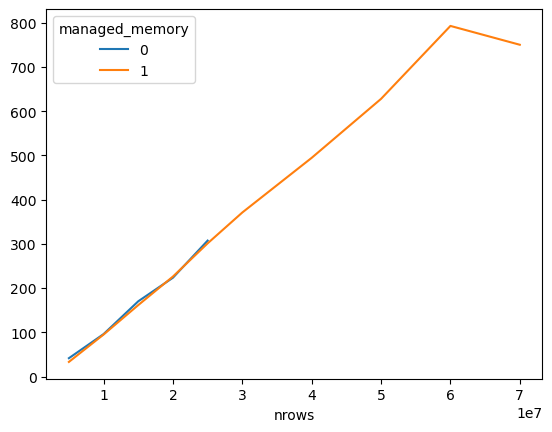

In [1]:
import pandas as pd
uvm_df = pd.read_json(path_or_buf="rf-benchmark-results-uvm.jsonl", lines=True)
no_uvm_df = pd.read_json(path_or_buf="rf-benchmark-results-no-uvm.jsonl", lines=True)
df = pd.concat([uvm_df, no_uvm_df])
df.to_csv("rf_sum.csv", index=False)
pivot = df.pivot(index='nrows', columns='managed_memory', values='fit_time')
pivot.plot()

# NEAREST NEIGHBORS

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import rmm
rmm.mr.set_current_device_resource(rmm.mr.ManagedMemoryResource())
print("MANAGED MEMORY ON")


MANAGED MEMORY ON


In [3]:
from cuml.neighbors import KNeighborsClassifier
from cuml.datasets import make_blobs
from cuml.model_selection import train_test_split
import pandas as pd
import cuml
import numpy as np
import os
import time
import cupy as cp
import json

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# cuml.common.logger.set_level(1)

class Timer:
    def __enter__(self):
        self.tick = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick


# Warmup
X = np.random.normal(0, 10, (100, 20))
y = np.random.randint(0, 2, 100)
clf = cuml.ensemble.RandomForestRegressor().fit(X, y)
clf = cuml.neighbors.KNeighborsRegressor().fit(X, y)


# n_samples = 50000000
# n_features = 256
# n_clusters = 8
# random_state = 0



# PARAMS
SKIP_SKLEARN = True

BACKENDS = [
    "cuml",
    "sklearn",
]

if SKIP_SKLEARN:
    BACKENDS.remove("sklearn")

NROWS = [
    5000000,
    10000000,
    15000000,
    20000000,
    25000000,
    30000000,
    40000000,
    50000000,
    60000000,
    70000000,
    80000000,
    90000000,
    100000000
]

NFEATURES = [
    256,
]

del clf


outpath = f"knn-benchmark-results-uvm.jsonl"
if os.path.exists(outpath):
    os.remove(outpath)


for N in NROWS:
    for K in NFEATURES:
        for library in BACKENDS:
            X, y = make_blobs(n_samples=N, centers=5,
                  n_features=K, random_state=5)
            X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 0 )

            benchmark_payload = {}
            with Timer() as fit_time:
                if library == "cuml":
                    knn = KNeighborsClassifier(n_neighbors=10)

                    knn.fit(X_train, y_train)


            benchmark_payload["backend"] = library
            benchmark_payload["nrows"] = N
            benchmark_payload["ncols"] = K
            benchmark_payload["fit_time"] = fit_time.elapsed
            benchmark_payload["managed_memory"] = 1
            print(benchmark_payload)

            with open(outpath, "a") as fh:
                fh.write(json.dumps(benchmark_payload))
                fh.write("\n")
            del knn
            del X, y, X_train, X_test, y_train, y_test

            time.sleep(0.5)

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


{'backend': 'cuml', 'nrows': 5000000, 'ncols': 256, 'fit_time': 0.7354159355163574, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 10000000, 'ncols': 256, 'fit_time': 0.030272722244262695, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 15000000, 'ncols': 256, 'fit_time': 0.042688608169555664, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 20000000, 'ncols': 256, 'fit_time': 0.0567774772644043, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 25000000, 'ncols': 256, 'fit_time': 0.06717061996459961, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 30000000, 'ncols': 256, 'fit_time': 0.08194351196289062, 'managed_memory': 1}
{'backend': 'cuml', 'nrows': 40000000, 'ncols': 256, 'fit_time': 0.10860538482666016, 'managed_memory': 1}


CUDADriverError: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

<Axes: xlabel='nrows'>

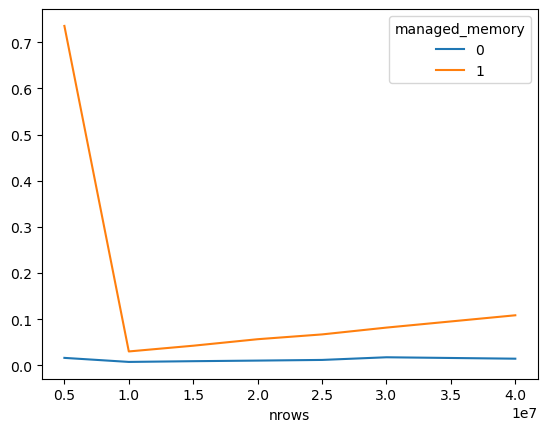

In [5]:
import pandas as pd
uvm_df = pd.read_json(path_or_buf="knn-benchmark-results-uvm.jsonl", lines=True)
no_uvm_df = pd.read_json(path_or_buf="knn-benchmark-results-no-uvm.jsonl", lines=True)
df = pd.concat([uvm_df, no_uvm_df])
df.to_csv("knn_sum.csv", index=False)
pivot = df.pivot(index='nrows', columns='managed_memory', values='fit_time')
pivot.plot()

# HDBSCAN

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
# import rmm
# rmm.mr.set_current_device_resource(rmm.mr.ManagedMemoryResource())
# print("MANAGED MEMORY ON")


In [3]:
from cuml.cluster.hdbscan import HDBSCAN
from cuml.datasets import make_blobs
from cuml.model_selection import train_test_split
import pandas as pd
import cuml
import numpy as np
import os
import time
import cupy as cp
import json

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# cuml.common.logger.set_level(1)

class Timer:
    def __enter__(self):
        self.tick = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick


# Warmup
X = np.random.normal(0, 10, (100, 20))
y = np.random.randint(0, 2, 100)
clf = cuml.ensemble.RandomForestRegressor().fit(X, y)
clf = cuml.neighbors.KNeighborsRegressor().fit(X, y)


# n_samples = 50000000
# n_features = 256
# n_clusters = 8
# random_state = 0



# PARAMS
SKIP_SKLEARN = True

BACKENDS = [
    "cuml",
    "sklearn",
]

if SKIP_SKLEARN:
    BACKENDS.remove("sklearn")

NROWS = [
    5000000,
    10000000,
    15000000,
    20000000,
    25000000,
    30000000,
    40000000,
    50000000,
    60000000,
    70000000,
    80000000,
    90000000,
    100000000
]

NFEATURES = [
    256,
]

del clf


outpath = f"hdbscan-benchmark-results-uvm.jsonl"
if os.path.exists(outpath):
    os.remove(outpath)


for N in NROWS:
    for K in NFEATURES:
        for library in BACKENDS:
            blobs, labels = make_blobs(n_samples=N, centers=5,
                  n_features=K, random_state=5)

            benchmark_payload = {}
            with Timer() as fit_time:
                if library == "cuml":
                    clusterer = HDBSCAN(prediction_data=True)
                    clusterer.fit(blobs)

            benchmark_payload["backend"] = library
            benchmark_payload["nrows"] = N
            benchmark_payload["ncols"] = K
            benchmark_payload["fit_time"] = fit_time.elapsed
            benchmark_payload["managed_memory"] = 1
            print(benchmark_payload)

            with open(outpath, "a") as fh:
                fh.write(json.dumps(benchmark_payload))
                fh.write("\n")
            del clusterer
            del blobs, labels

            time.sleep(0.5)

/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/coder/.conda/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
